# Initial Data Exploration and ETL Process

---

This notebook works through the initial data exploration phase and the ETL process. Main objective of this notebook is to understand the data and adress data quality. Additionally, following the ETL process, the HAM10000 data will be transformed into the required federated data pipeline.

Data Source used in this notebook:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000



## Installations before we start


In [1]:
# update pytorch and fastai to latest versions
!pip install torch -U
!pip install torchvision -U
!pip install fastai -U 
!pip install -q kaggle

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.60)


In [2]:
# import the usual frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import warnings
import json
import os

from IPython.core.display import display, HTML
    
# import plotly 
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls

# for color scales in plotly
import colorlover as cl 

# import deep learning libraries
import torch
import fastai
from fastai import *
from fastai.vision import *

from sklearn.metrics import auc, roc_curve, roc_auc_score

# configure things
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format  
pd.options.display.max_columns = 999

py.init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Setting up the Kaggle API

In [3]:
# mount your google drive so you can save to it. You'll need to put in a token.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#from google.colab import files
#files.upload()

In [0]:
# create environment variables for kaggle to authenticate with
os.environ['KAGGLE_USERNAME'] = "user_name"
os.environ['KAGGLE_KEY'] = "user_key

In [6]:
##os.mkdir('c_skin')
os.listdir()

['.config', 'gdrive', 'kaggle.json', 'sample_data']

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

## Extracting the HAM10000 dataset

In [8]:
# get the dataset from kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p 'c_skin'

100% 5.18G/5.20G [01:12<00:00, 62.1MB/s]
100% 5.20G/5.20G [01:12<00:00, 76.9MB/s]


In [0]:
# ! kaggle datasets list

In [9]:
# Unzip the whole zipfile into /c_skin
!unzip -o c_skin/skin-cancer-mnist-ham10000.zip -d c_skin

# Quietly unzip the image files
#!unzip -o -q c_skin/HAM10000_images_part_1 -d c_skin
#!unzip -o -q c_skin/HAM10000_images_part_2 -d c_skin

# Tell me how many files I unzipped///
!echo files in c_skin: `ls c_skin | wc -l`

Streaming output truncated to the last 5000 lines.
  inflating: c_skin/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: c_skin

In [10]:
!ls c_skin

ham10000_images_part_1	HAM10000_metadata.csv  hmnist_8_8_RGB.csv
HAM10000_images_part_1	hmnist_28_28_L.csv     skin-cancer-mnist-ham10000.zip
ham10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_2	hmnist_8_8_L.csv


### Load data into pandas df

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob

In [0]:
# Building the path column for the individual images is a bit tricky 
# First I define my base_skin_dir which will be used for the imageid_path_dic
base_skin_dir = os.path.join('c_skin')

In [0]:
# This os.path method to create the image path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [0]:
# Create dictionary of the different lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [15]:
# Let's read the HAM10000_metadata.csv into the tile_df
tile_df = pd.read_csv('c_skin/HAM10000_metadata.csv')
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.00,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.00,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.00,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.00,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.00,male,ear


### Cleaning the data 

In [16]:
# Inspect the df for missing values and the datatype of each field 
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [0]:
# As seen in the cell above, there is 57 null values for the field age
# Thus, the following code will replace these null values with the mean age 
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

In [20]:
# Verify that this worked and no more null values are present in the df
tile_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [22]:
# Let's check the data types for each column in the df
print(tile_df.dtypes)

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object


## Load images into pandas df

In [23]:
# Let's create a new column for the image path
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
7585,HAM_0004221,ISIC_0033163,nv,histo,35.00,female,chest,c_skin/HAM10000_images_part_2/ISIC_0033163.jpg
3304,HAM_0000912,ISIC_0026232,nv,follow_up,45.00,female,abdomen,c_skin/HAM10000_images_part_1/ISIC_0026232.jpg
3011,HAM_0001180,ISIC_0029303,nv,follow_up,50.00,male,trunk,c_skin/HAM10000_images_part_1/ISIC_0029303.jpg
802,HAM_0002903,ISIC_0024774,bkl,confocal,35.00,female,face,c_skin/HAM10000_images_part_1/ISIC_0024774.jpg
2638,HAM_0002243,ISIC_0033609,bcc,histo,80.00,male,back,c_skin/HAM10000_images_part_2/ISIC_0033609.jpg


In [24]:
# Create the cell_type_idx column, which represents the lesion type in numeric value
# Later the celltype_idx and and image features will be needed for the tf data pipeline
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
4801,HAM_0002068,ISIC_0029710,nv,follow_up,45.00,female,back,c_skin/HAM10000_images_part_2/ISIC_0029710.jpg,Melanocytic nevi,4
8791,HAM_0005822,ISIC_0029054,nv,histo,45.00,male,upper extremity,c_skin/HAM10000_images_part_1/ISIC_0029054.jpg,Melanocytic nevi,4
2237,HAM_0004878,ISIC_0026802,mel,histo,85.00,male,back,c_skin/HAM10000_images_part_1/ISIC_0026802.jpg,dermatofibroma,6
1443,HAM_0003376,ISIC_0025394,mel,histo,45.00,male,trunk,c_skin/HAM10000_images_part_1/ISIC_0025394.jpg,dermatofibroma,6
2954,HAM_0005837,ISIC_0028653,bcc,histo,50.00,female,chest,c_skin/HAM10000_images_part_1/ISIC_0028653.jpg,Basal cell carcinoma,1


In [0]:
# Load all the images via the path creating new image column
from skimage.io import imread
tile_df['image'] = tile_df['path'].map(imread)

In [27]:
# See the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

### Explore the image data

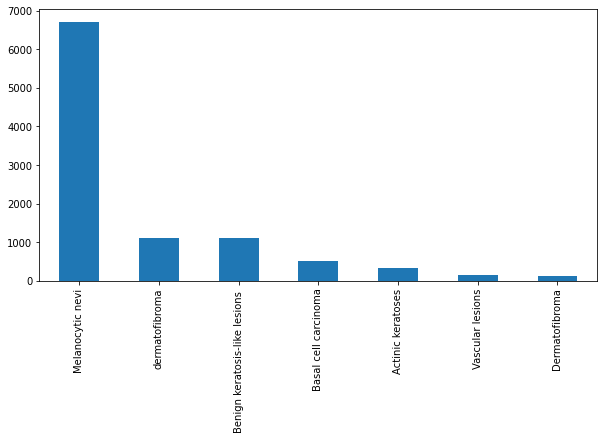

In [28]:
# Using matplotlib to visualize the number of images per lesion type
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

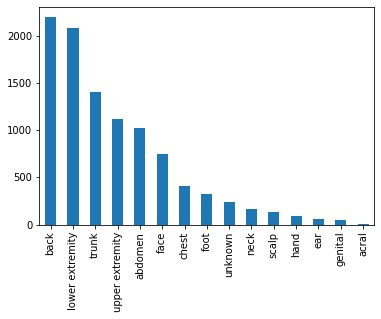

In [34]:
# Plotting the distribution of localization
tile_df['localization'].value_counts().plot(kind='bar')

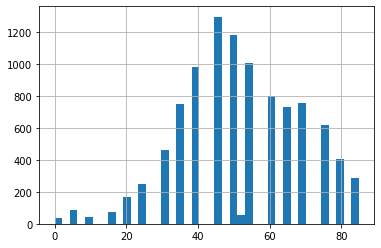

In [35]:
# Check the age distribution of the data set
tile_df['age'].hist(bins=40)

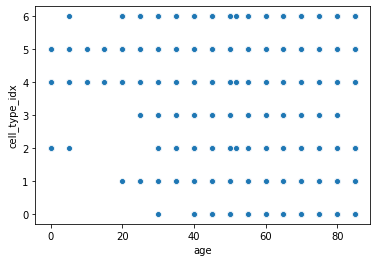

In [37]:
# Visualization of age distribution and skin lesion types
sns.scatterplot('age','cell_type_idx',data=tile_df)

### Show images in each category

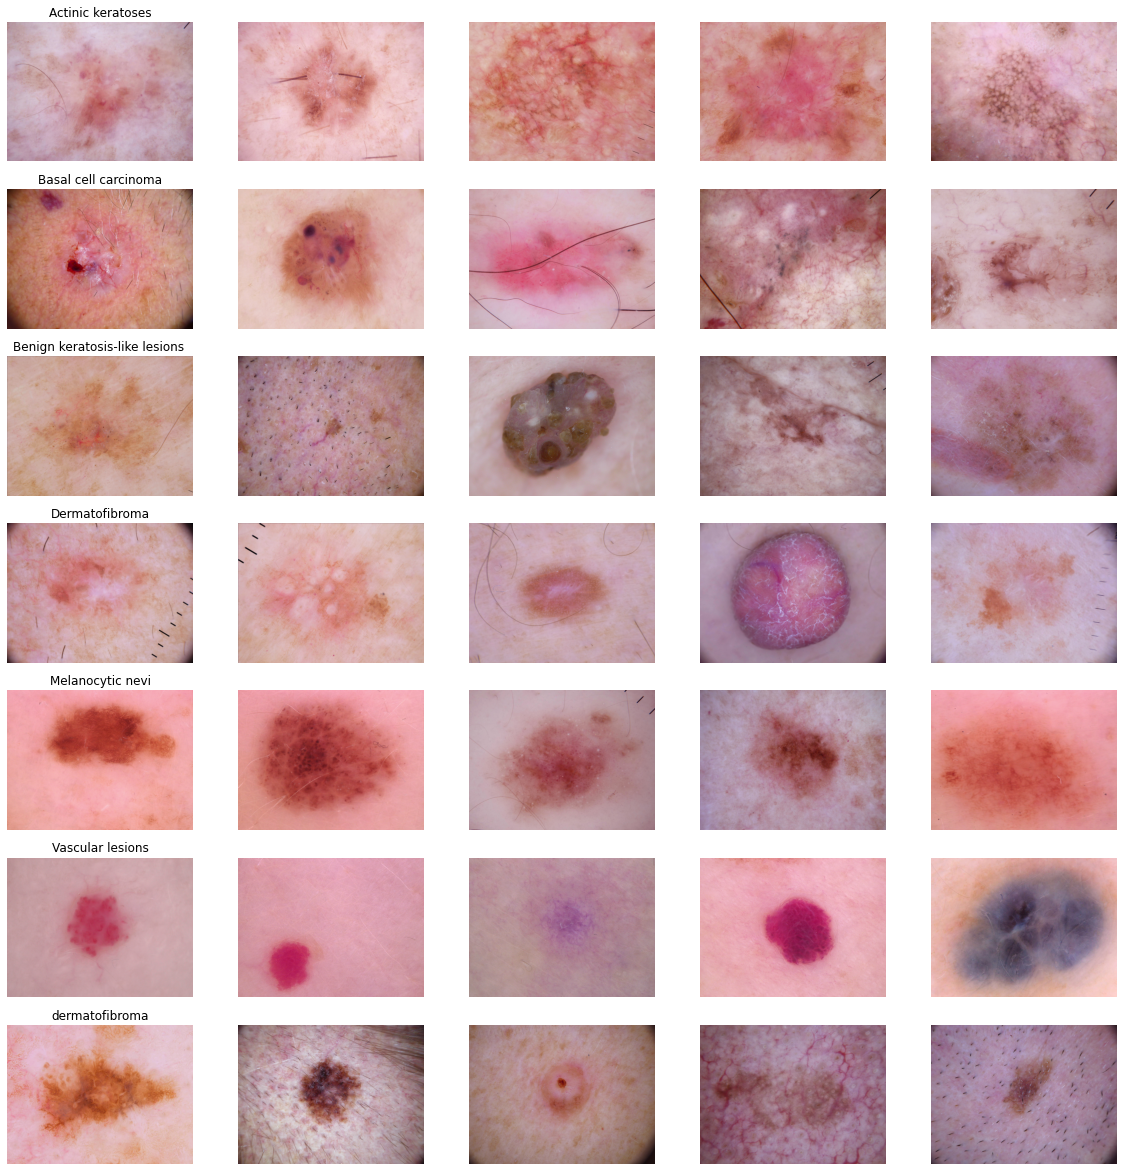

In [30]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [32]:
tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
2370,5,Vascular lesions
1577,6,dermatofibroma


## Resizing the images to 28x28

Create a df with only the image(pixel) and the lable. The emnist data set in the federated example has the following `element_type_structure`

OrderedDict([('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None)), ('label', TensorSpec(shape=(), dtype=tf.int32, name=None))])

In [0]:
# https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html#sphx-glr-download-auto-examples-transform-plot-rescale-py

from PIL import Image, ImageFont
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [40]:
# Lets check the image size distribution again and see if the resizing worked 
tile_df['image'].map(lambda x: x.shape).value_counts()

(28, 28, 3)    10015
Name: image, dtype: int64

In [45]:
ham_df = tile_df[['image', 'cell_type_idx']]
ham_df

,image,cell_type_idx
0,"[[[192, 153, 193], [195, 155, 192], [197, 154,...",2
1,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ...",2
2,"[[[192, 138, 153], [200, 144, 162], [202, 142,...",2
3,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],...",2
4,"[[[159, 114, 140], [194, 144, 173], [215, 162,...",2
...,...,...
10010,"[[[183, 166, 182], [183, 165, 181], [184, 167,...",0
10011,"[[[3, 4, 2], [41, 36, 35], [119, 103, 102], [1...",0
10012,"[[[134, 120, 120], [166, 148, 149], [175, 155,...",0
10013,"[[[160, 124, 145], [164, 131, 151], [166, 127,...",0


In [47]:
# Rename the columns titles
ham_dataset = ham_df.rename(columns={"image": "images", "cell_type_idx": "labels"})
ham_dataset.head()

,images,labels
0,"[[[192, 153, 193], [195, 155, 192], [197, 154,...",2
1,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ...",2
2,"[[[192, 138, 153], [200, 144, 162], [202, 142,...",2
3,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],...",2
4,"[[[159, 114, 140], [194, 144, 173], [215, 162,...",2


In [66]:
# Save a copy of the preprocessed ham_dataset file to My Drive
from google.colab import drive
drive.mount('/drive')
ham_dataset.to_csv('/drive/My Drive/Colab_Data/ham_dataset_28x28.csv')

Mounted at /drive


### Packaging the dataset

In [0]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [69]:
# Loading image data into tfds format
DATA_URL = 'https://drive.google.com/drive/folders/1ZoNx2IpYg0LI6xIjc8z5NuhE1bv4vhZh'
data_root_orig = tf.keras.utils.get_file(fname='ham_dataset_28x28',origin=DATA_URL,untar=True)
data_root = pathlib.Path(data_root_orig)

ERROR! Session/line number was not unique in database. History logging moved to new session 62
   8192/Unknown - 0s 0us/step

In [55]:
dataset = tf.data.Dataset.from_tensor_slices((ham_dataset.images, ham_dataset.labels))

ERROR! Session/line number was not unique in database. History logging moved to new session 59


ValueError: ignored

## Trial loading data to TFF

In [0]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow_federated

# NOTE: Jupyter requires a patch to asyncio.
!pip install --quiet --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

%load_ext tensorboard

     |████████████████████████████████| 419kB 3.6MB/s 
     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 2.2MB 45.7MB/s 
     |████████████████████████████████| 296kB 57.3MB/s 
     |████████████████████████████████| 993kB 42.2MB/s 
     |████████████████████████████████| 3.8MB 42.2MB/s 
     |████████████████████████████████| 450kB 42.9MB/s 


In [0]:
import collections
import warnings
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

warnings.simplefilter('ignore')

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

[autoreload of grpc failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]


b'Hello, World!'

In [0]:
TRAIN_DATA_URL = 'https://drive.google.com/open?id='
TEST_DATA_URL = 'https://drive.google.com/open?id='

train_file_path = tf.keras.utils.get_file("name_of_file.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("name_of_file.csv", TEST_DATA_URL)

# Not sure if this is the right approach
# https://medium.com/@a.ydobon/tensorflow-2-0-load-csv-to-tensorflow-2634f7089651

  73728/Unknown - 0s 0us/stepDownloading data from https://drive.google.com/open?id=1KheH8_sMyTufkWEPFMi4QdAXfV0Kzf4o
  73728/Unknown - 0s 0us/step